# MW-LMC Example

A simple work-through example to model the Large Magellanic Cloud (LMC) as a perturbation to the Milky Way potential

In [1]:
import logging

import galax.potential as gp
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from flax import nnx

from galactoPINNs.data import (
    generate_static_data,
    generate_xy_plane_grid,
    scale_data,
)
from galactoPINNs.evaluate import evaluate_performance
from galactoPINNs.layers import TrainableGalaxPotential
from galactoPINNs.model_potential import (
    make_galax_potential,
)
from galactoPINNs.models.static_model import StaticModel
from galactoPINNs.train import alternate_training, train_model_static, train_step_static

## Set up logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
)

In [2]:
####
### Generate synthetic data for training and testing
####

true_MW_potential = gp.MilkyWayPotential()
true_lmc_potential = gp.NFWPotential(m=1.0e11, r_s=5.0, units="galactic")
lmc_center = jnp.array([50.0, 0.0, 0.0])  # in kpc
lmc_pot_centered = gp.TranslatedPotential(true_lmc_potential, translation=lmc_center)

true_potential = true_MW_potential + lmc_pot_centered
analytic_baseline_potential = gp.NFWPotential(m=5.4e11, r_s=15.62, units="galactic")

In [3]:
####
### Generate the training and testing sets
####

raw_datadict = generate_static_data(
    galax_potential=true_potential,
    n_samples_train=2048,
    n_samples_test=4096,
    r_max_train=100,      # kpc
    r_max_test=150,       # kpc
)

In [4]:
####
### Nondimensionalize the data, and set up the model configuration
####

r_s = 15.62
include_analytic_baseline = True

scale_config = {
    "r_s": r_s,
    "include_analytic": include_analytic_baseline,
    "ab_potential": analytic_baseline_potential,
}

# nondimensionalize the data
scaled_data, transformers = scale_data(raw_datadict, scale_config)

# configure the desired model features
train_config = {
    "x_transformer": transformers["x"],
    "a_transformer": transformers["a"],
    "u_transformer": transformers["u"],
    "r_s": r_s,
    "include_analytic": include_analytic_baseline,
    "depth": 6,
    "scale": "one",
    "scale_reciprocal": False,
    "trainable": True,  # setting trainable = False will use the fixed analytic baseline only
}

x_train = scaled_data["x_train"]
a_train = scaled_data["a_train"]

In [4]:
# ###
# ## Initialize and train a model with a non-trainable baseline potential
# ###

# ## set up the model and hyperparameters
# l_rel = 0.5  # weight for the relative loss term
# lr0 = 1e-3  # initial learning rate
# tx = optax.adam(lr0)
# net = StaticModel(train_config,rngs=nnx.Rngs(0))

# ## set up the optimizer
# opt = nnx.Optimizer(net, optax.adam(1e-3), wrt=nnx.Param)

# ## train the model
# out = train_model_static(net, tx, x_train, a_train, 2000, analytic_potential=analytic_baseline_potential)

In [ ]:
# ####
# ### Set up and train a model with a trainable analytic baseline potential
# ###
# ####

lr0 = 2e-3   # initial learning rate
l_rel = 0.5  # weight for the relative loss term

trainable_params = ("m", "r_s")  # parameters of the baseline NFWPotential to be optimized

trainable_analytic_baseline = TrainableGalaxPotential(
    PotClass=gp.NFWPotential,
    init_kwargs={"m": 5.4e11, "r_s": 15.62},
    trainable=trainable_params,
)

net = StaticModel(train_config, rngs=nnx.Rngs(0), trainable_analytic_layer= trainable_analytic_baseline)
tx_base = optax.adam(lr0)
opt1 = nnx.Optimizer(net, tx_base, wrt=nnx.PathContains("trainable_analytic_layer"))
opt2 = nnx.Optimizer(net, tx_base, wrt=nnx.Param)

In [11]:
# ####
# ### Train the model with alternate training between the analytic-focused and NN-focused stages.
# ### Should converge in < 2 min; for optimal results, train for longer.
# ####

train_out = alternate_training(
    train_step_static,
    x_train,
    a_train,
    net,
    num_epochs_stage1=2000,
    num_epochs_stage2=3000,
    cycles=1,
    param_list=trainable_params,
    optimizer1 = opt1,
    optimizer2 = opt2,
    lambda_rel=l_rel,
    log_every = 100
)

2026-01-28 17:48:22,838 | INFO | galactoPINNs.train | === Starting Cycle 1 / 1: Stage 1 ===
2026-01-28 17:48:22,839 | INFO | galactoPINNs.train | Training for 2000 epochs...
2026-01-28 17:48:22,851 | INFO | galactoPINNs.train | Epoch 1, Loss: 0.113952
2026-01-28 17:48:23,410 | INFO | galactoPINNs.train | Epoch 101, Loss: 0.113439
2026-01-28 17:48:23,963 | INFO | galactoPINNs.train | Epoch 201, Loss: 0.113418
2026-01-28 17:48:24,505 | INFO | galactoPINNs.train | Epoch 301, Loss: 0.113392
2026-01-28 17:48:25,063 | INFO | galactoPINNs.train | Epoch 401, Loss: 0.113364
2026-01-28 17:48:25,675 | INFO | galactoPINNs.train | Epoch 501, Loss: 0.113336
2026-01-28 17:48:26,226 | INFO | galactoPINNs.train | Epoch 601, Loss: 0.113307
2026-01-28 17:48:26,819 | INFO | galactoPINNs.train | Epoch 701, Loss: 0.113281
2026-01-28 17:48:27,474 | INFO | galactoPINNs.train | Epoch 801, Loss: 0.113256
2026-01-28 17:48:28,055 | INFO | galactoPINNs.train | Epoch 901, Loss: 0.113233
2026-01-28 17:48:28,622 | IN

In [12]:
# ###
# ## Evaluate the performance
# ###
perf = evaluate_performance(train_out["model"], raw_datadict, 200)
print(perf["avg_percent_error"])

0.5929151


In [ ]:
####
### Instantiate a Galax potential backed by the learned potential
####

learned_potential = make_galax_potential(
    model=train_out["model"],
    analytic_baseline_potential= None
)


In [14]:
####
### Set up evaluation grid in the x-y plane
####
xy_points = generate_xy_plane_grid(-70, 70, -70, 70, num_x=70, num_y=70)  # in kpc
true_potential_xy = true_potential.potential(xy_points, t=0)
true_acc_xy = true_potential.acceleration(xy_points, t=0)
true_acc_norm_xy = jnp.linalg.norm(true_acc_xy, axis=1)

predicted_potential_xy = learned_potential.potential(xy_points, t=0)
predicted_acc_xy = learned_potential.acceleration(xy_points, t=0)

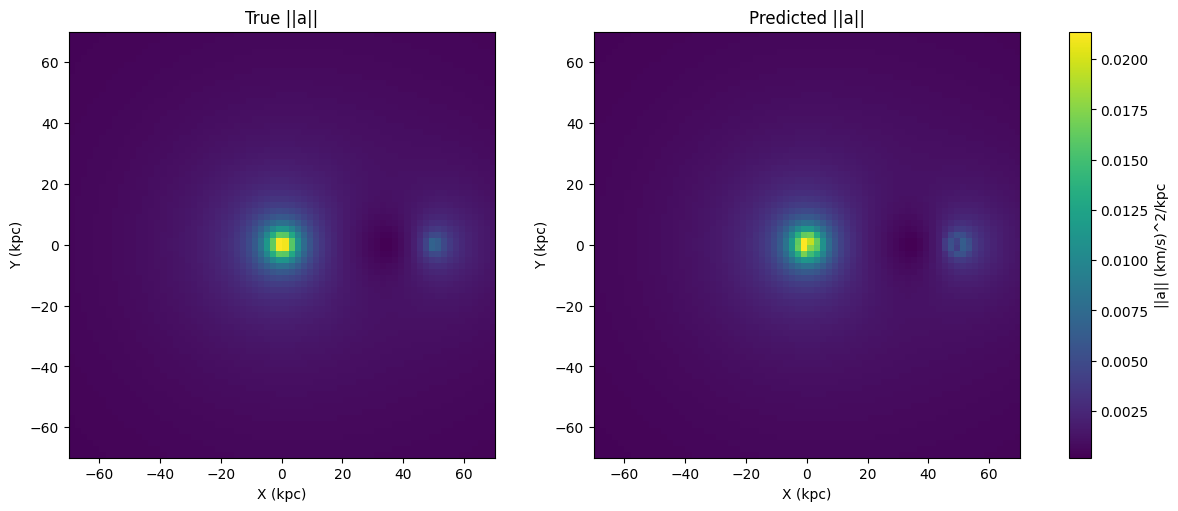

In [15]:
####
### Visualize the results
####

nx = ny = int(jnp.sqrt(len(xy_points)))
x = xy_points[:, 0].reshape((ny, nx))
y = xy_points[:, 1].reshape((ny, nx))

true_u = true_potential_xy.reshape((ny, nx))
pred_u = predicted_potential_xy.reshape((ny, nx))

predicted_acc_norm_xy = jnp.linalg.norm(predicted_acc_xy, axis=1)
true_acc_norm = true_acc_norm_xy.reshape((ny, nx))
pred_acc_norm = predicted_acc_norm_xy.reshape((ny, nx))

vmin = jnp.min(true_acc_norm)
vmax = jnp.max(true_acc_norm)

############
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

im0 = axs[0].imshow(
    true_acc_norm,
    origin="lower",
    extent=[x.min(), x.max(), y.min(), y.max()],
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
)
axs[0].set_xlabel("X (kpc)")
axs[0].set_ylabel("Y (kpc)")
axs[0].set_title("True ||a||")


im1 = axs[1].imshow(
    pred_acc_norm,
    origin="lower",
    extent=[x.min(), x.max(), y.min(), y.max()],
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
)
axs[1].set_title(r"Predicted $\phi$")
axs[1].set_xlabel("X (kpc)")
axs[1].set_ylabel("Y (kpc)")
axs[1].set_title("Predicted ||a||")
fig.colorbar(im1, ax=axs.ravel().tolist(), label="||a|| (km/s)^2/kpc")

plt.show()